# Klasyfikacja obrazów zwierząt

Cel klasyfikacja obrazów zwierząt do jednej z dziesięcu klas:
$$
[butterfly,cat, chicken, cow, dog, elephant, horse, sheep, spider, squirrel]
$$

za pomocą **Convolutional Neural Networks (CNN)**. Dla każdej klasy jest około 2 tysiące obrazów.

Źródło danych: https://www.kaggle.com/datasets/alessiocorrado99/animals10

In [31]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, alexnet
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import utils

torch.manual_seed(423)
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
TRAIN_MEAN = [0.5036, 0.4719, 0.3897]
TRAIN_STD = [0.2623, 0.2577, 0.2671]
classes = ['butterfly','cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']

## Problemy związane z przyjęciem obrazów jako wejscie dla modeli
### Przykładowe obrazy w zbiorze

In [32]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_data = ImageFolder(root='dataset/train/', transform=transform)
batch_size = 1
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

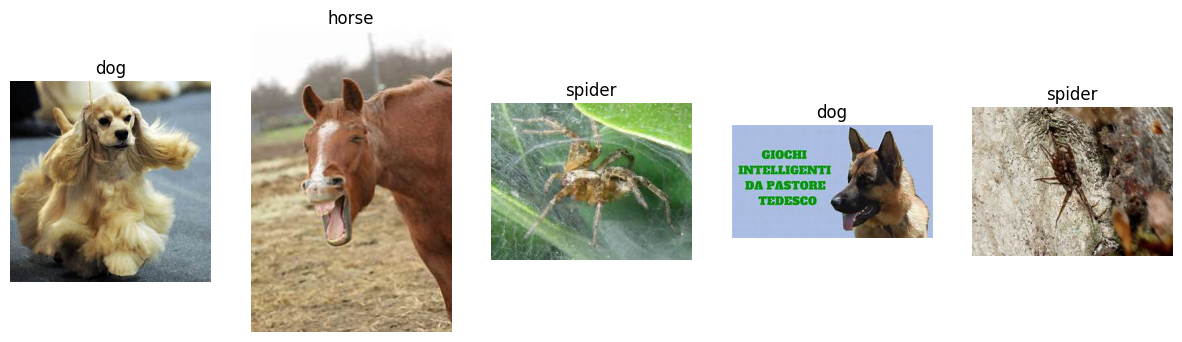

In [33]:
fig, ax = plt.subplots(1, 5, figsize=(15,15))
for i in range(5):
    data, labels = next(iter(train_loader))
    img = data[0].permute(1,2,0)
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(classes[labels[0].item()])

Podobnie jak w przypadku danych tabelarycznych oczekujemy pewnego określonego wymiaru danych wejsciowych. W tym przypadku każdy obraz możemy traktowac jako tabele o wymiarach $H\times W\times C$ - wysokosc, szerokość i kanały koloru (RGB), a informacją jest wartość pixela $[0-255]$ (lub $[0-1]$ po znormalizowaniu).

In [34]:
data[0].shape, data[0,:, :5, :5], 

(torch.Size([3, 223, 300]),
 tensor([[[0.7294, 0.7137, 0.7843, 0.7529, 0.8275],
          [0.7490, 0.7412, 0.7882, 0.7333, 0.7882],
          [0.7216, 0.7373, 0.7765, 0.7333, 0.7882],
          [0.7020, 0.7373, 0.7608, 0.7412, 0.7922],
          [0.7412, 0.7647, 0.7569, 0.7608, 0.7725]],
 
         [[0.7020, 0.6863, 0.7569, 0.7255, 0.7922],
          [0.7216, 0.7137, 0.7608, 0.7059, 0.7529],
          [0.6941, 0.7098, 0.7490, 0.7059, 0.7529],
          [0.6745, 0.7098, 0.7333, 0.7137, 0.7569],
          [0.7137, 0.7373, 0.7294, 0.7333, 0.7373]],
 
         [[0.6392, 0.6235, 0.6941, 0.6627, 0.7255],
          [0.6588, 0.6510, 0.6980, 0.6431, 0.6863],
          [0.6314, 0.6471, 0.6863, 0.6431, 0.6863],
          [0.6118, 0.6471, 0.6706, 0.6510, 0.6902],
          [0.6510, 0.6745, 0.6667, 0.6706, 0.6706]]]))

### Preprocessing obrazów
Poniewaz obrazy mają różne wymiary przyjęto podejście zwiększenia najmniejszego z wymiarów do $[256\times W]$ lub $[H\times 256]$, a drugi wymiar zwiększany jest zgodnie z zachowaniem aspect ratio oryginalnego obrazu co pozwala na uniknięcie zniekształceń kształtów np. spłaszczenie głowy. Natomiast chcemy mięć obrazy o stałym wymiarze np. $[256\times 256]$ więc robimy losowe wycięcie takiego obszaru z powiększonego obrazu. Dodatkowa transformacja dla polepszenia procesu uczenia sieci to standaryzacja wartosci pixeli.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


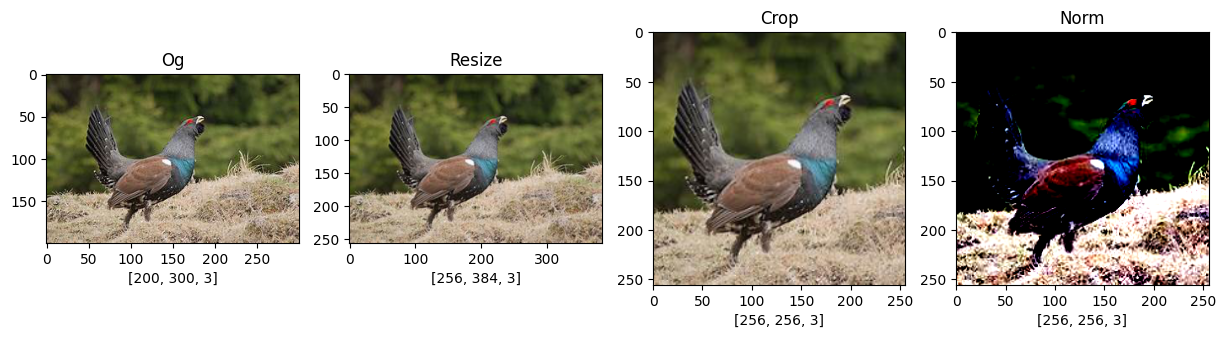

In [35]:
data, labels = next(iter(train_loader))
fig, ax = plt.subplots(1, 4, figsize=(15,15))
# oryginalny obraz
og_img = data[0].permute(1,2,0)
# resize obrazu
resize = transforms.Resize(256)(data)
resized_img = resize[0].permute(1,2,0)
# crop obrazu
crop= transforms.RandomCrop(size=(256,256))(resize)
cropped_img = crop[0].permute(1,2,0)
# normalizacja
norm = transforms.Normalize(TRAIN_MEAN, TRAIN_STD)(crop)
norm_img = norm[0].permute(1,2,0)

names = ['Og', 'Resize', 'Crop', 'Norm']
for i, (im, name) in enumerate(zip([og_img, resized_img, cropped_img, norm_img], names)):
    ax[i].imshow(im)
    ax[i].set_title(name)
    ax[i].set_xlabel(list(im.shape))

### Filtry liniowe i operacja konwolucji

Filtorwanie obrazu w celu pozyskania pewnych cech z obrazów. W najprostszy sposób możemy po prostu spłaszczyć macierz obrazu w jednowymiarowy wektor, ale tracimy informacje o lokalnych cechach wystepujących w obrazie.

Sposobem przetworzenia obrazu z wykorzystaniem lokalnych filtrów jest operacja konwolucji obrazu z jądrem/kernel, przykłady:

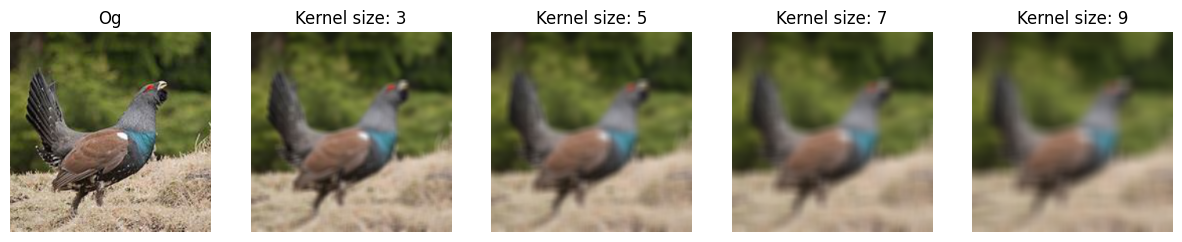

In [36]:
fig, ax = plt.subplots(1, 5, figsize=(15,15))

og_img = Image.fromarray((cropped_img.numpy()*255).astype('uint8'))
ax[0].imshow(cropped_img)
ax[0].set_title(f'Og')
ax[0].axis('off')

for i, ker_size in enumerate([3,5,7,9]):
    im = og_img.filter(ImageFilter.BoxBlur(ker_size))
    im = np.array(im)
    ax[i+1].imshow(im)
    ax[i+1].axis('off')
    ax[i+1].set_title(f'Kernel size: {ker_size}')

Przykładowe kernele $3\times 3$ i $5\times 5$ uśredniające wartości pixeli na lokalnym obszarze obrazu. Wartość sumuje się do jedynki, by nie wzmacniać/usłabiać wartości na danym obszarze.

In [37]:
ker_3, ker_5 = np.ones(shape=(3,3))/9, np.ones(shape=(5,5))/25
ker_3, ker_5

(array([[0.11111111, 0.11111111, 0.11111111],
        [0.11111111, 0.11111111, 0.11111111],
        [0.11111111, 0.11111111, 0.11111111]]),
 array([[0.04, 0.04, 0.04, 0.04, 0.04],
        [0.04, 0.04, 0.04, 0.04, 0.04],
        [0.04, 0.04, 0.04, 0.04, 0.04],
        [0.04, 0.04, 0.04, 0.04, 0.04],
        [0.04, 0.04, 0.04, 0.04, 0.04]]))

[[[42 38 24]
  [42 35 24]
  [42 35 25]]

 [[41 37 23]
  [41 34 24]
  [42 35 25]]

 [[39 36 21]
  [40 33 23]
  [41 34 24]]]


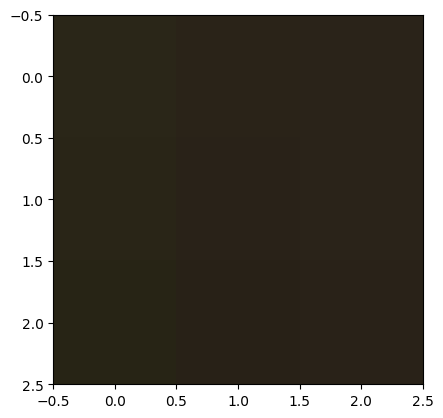

In [38]:
img = (cropped_img.numpy()*255).astype('uint8')[:3, :3, :]
print(img)
plt.imshow(img)
plt.show()

Wynikające wartości pixela na kanałach RGB z konwolucji, dla każdego z kanałów. Jest to wartość wyłącznie dla pixela H,W = (1,1) na podstawie jego otoczenia. Taka operację nalezy przeprowadzić na otoczeniach wszystkich pixeli, aby uzyskać zblurowany obraz.

In [42]:
np.einsum('jk, ijk -> k', ker_3, img).astype('uint8')

array([41, 35, 23], dtype=uint8)

Specjalistyczne ręcznie dobrane filtry do wykrywania wybranych cech jak np. krawędzie obiektów w obrazie (Sobel Filter), są one inspiracją dla sieci typu CNN by automatycznie uczyły się takich filtrów.

![sobel](spraw_imgs/sobel_filtering.png)

Źródło obrazów: https://en.wikipedia.org/wiki/Sobel_operator

In [40]:
np.array([[1,0,-1], [+2, 0, -2], [1,0,-1]]), np.array([[1,2,1], [0, 0, 0], [-1,-2,-1]])

(array([[ 1,  0, -1],
        [ 2,  0, -2],
        [ 1,  0, -1]]),
 array([[ 1,  2,  1],
        [ 0,  0,  0],
        [-1, -2, -1]]))

## Sieci CNN

Architektura prostej sieci CNN (LeNet):
1. Ekstrakcja cech -  warstwa konwolucyjna, warstwy z filtrami o różnej wielkości. Celem jest, aby sieć by sama nauczyla się potrzebnych jej filtrów do rozróżniania cech danych klas.
2. Klasyfikator - koncepcyjnie mamy np. 200 filtrów w ostatniej warstwie konwolucyjnej, "spłaszczamy" informację do 1D tensora, np. binarna informacja 0-1 dla filtru o kształcie kocich uszu. Dalej standardowa sieć neuronowa z celem klasyfikacji obiektu do jednej z  10 klas.

![lenet](spraw_imgs/lenet.png)

Źródło obrazu: http://d2l.ai/chapter_convolutional-neural-networks/lenet.html

3. Wyjście sieci - funkcja **softmax** by informacje liczbową wyjść przedstawić w formie prawdopodobieństwa przynależności do klasy. Taki wektor po wyjściu z funkcji softmax sumuje się do 1, a przynależność do klasy określamy po indeksie maksymalnej wartości.

$$
softmax(y) = \left[
    \frac{e^{y_1}}{\sum_j^C e^{y_j}}, 
    \frac{e^{y_2}}{\sum_j^C e^{y_j}}, 
    \dots,
    \frac{e^{y_C}}{\sum_j^C e^{y_j}}
\right]
$$

4. Funkcja celu - **Cross Entropy Loss**
$$
CE(P^*|P) = -\sum_j^C P^*(j)\log P(j)
$$
- $P^*$ - wektor prawdziwych wartości
- $P$ - wektor predykcji

Co uproszcza się do $-\log P(c)$, gdyż wektor $P^*$ przyjmuje postać $[0,\dots ,1,\dots ,0]$ więc pozostałe elementy sumy się zerują.

### Uczenie sieci

- Algorytm optymalizacja wag za pomocą **Mini Batch Stochastic Gradient Descent** z regularyzacją wag
- Batch Size - 32 obrazy per batch, okolo 560 batchy, kwestia pomieszczenia wag parametrów sieci i obrazów w pamięci GPU, by przyśpieszyć obliczenia
- Nauczono trzy architektury sieci: **LeNet**, **AlexNet**, **ResNet**
- Dwa podejścia uczenia wag: od zera z losowymi wagami oraz transfer learning

**Transfer learning** - sieć z wagami nauczonymi na zbiorze ImageNet (1 mln obrazów, 1000 klas), polega to na dostosowaniu wyjścia sieci do problemu (1000 -> 10) i "douczenia" wcześniejszych warstw z mniejszym krokiemm niż warstwa wyjściowa. Takie podejście jest bardzo efektywne, gdyż te sieci zostały nauczone do osiągnięcia wysokiej skuteczności wcześniej i upublicznione, a wyuczone filtry dostoswują się do nowego problemu.

### LeNet i AlexNet

![alexnet](spraw_imgs/alexnet.png)

Źródło obrazu: http://d2l.ai/chapter_convolutional-modern/alexnet.html#alexnet

### ResNet

Residual block - uproszcza uczenie sieci zakreskowany obszar nie musi sie uczyc całej funkcji $f(x)$, a uczy się uproszczonej wersji a reszta jest dociągana do wyjścia. Upraszcza to bo przed funkcja aktywacją komibnacja wyjścia jest sumą kombinacji liniowych. 

![resnet-block](spraw_imgs/resnet-block.png)

Architektura sieci

![resnet18-90](spraw_imgs/resnet18-90.png)

Źródło obrazów http://d2l.ai/chapter_convolutional-modern/resnet.html

## Wyniki